# Preliminar

In [2]:
import pandas as pd 
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from optuna.integration import XGBoostPruningCallback
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import joblib

X0=pd.read_parquet('X_t0.parquet')
X1=pd.read_parquet('X_t1.parquet')
X2=pd.read_parquet('X_t2.parquet')
y0=pd.read_parquet('y_t0.parquet')
y1=pd.read_parquet('y_t1.parquet')

In [3]:
data_train, data_val, y_train, y_val = train_test_split(X0, y0, test_size=0.3, stratify=y0, random_state=17)

print(f"Entrenamiento: {data_train.shape}, Validación: {data_val.shape}")

Entrenamiento: (31007, 77), Validación: (13289, 77)


# Métricas en validación

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import finalize_model, predict_model

def validacion_modelo(best_model, data_val):
    """
    Evalúa el modelo `best_model` de PyCaret usando un conjunto de validación `data_val`.
    Calcula el reporte de clasificación y la matriz de confusión, y visualiza los resultados
    para el `best_model` y el `finalized_model`.

    Parameters:
    - best_model: El mejor modelo entrenado de PyCaret.
    - data_val: El conjunto de datos de validación con la columna objetivo.
    - target_column: El nombre de la columna objetivo (predicción), por defecto es 'previo_fallo'.
    """
    # Finalizar el mejor modelo
    finalized_model = finalize_model(best_model)

    # Predecir utilizando el best_model
    validation_results_best = predict_model(best_model, data=data_val)

    # Predecir utilizando el finalized_model
    validation_results_finalized = predict_model(finalized_model, data=data_val)

    # Obtener las etiquetas verdaderas y predichas para ambos modelos
    y_true = y_val['target']
    y_pred_best = validation_results_best['prediction_label']
    y_pred_finalized = validation_results_finalized['prediction_label']

    # Cálculo del AUC-PR
    auc_pr_best = average_precision_score(y_true, y_pred_best)
    auc_pr_finalized = average_precision_score(y_true, y_pred_finalized)
    
    # Reporte de clasificación para el best_model
    print("Reporte de Clasificación para el Best Model:")
    print("\nAUC-PR", auc_pr_best)
    print(classification_report(y_true, y_pred_best))
    
    # Reporte de clasificación para el finalized_model
    print("\nReporte de Clasificación para el Finalized Model:")
    print("AUC-PR:", auc_pr_finalized)
    print(classification_report(y_true, y_pred_finalized))

    # Matriz de confusión para el best_model
    conf_matrix_best = confusion_matrix(y_true, y_pred_best)
    
    # Matriz de confusión para el finalized_model
    conf_matrix_finalized = confusion_matrix(y_true, y_pred_finalized)

    # Visualización de la matriz de confusión para el best_model
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Fallo', 'Fallo'], yticklabels=['No Fallo', 'Fallo'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión para el Best Model')

    # Visualización de la matriz de confusión para el finalized_model
    plt.subplot(1, 2, 2)
    sns.heatmap(conf_matrix_finalized, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Fallo', 'Fallo'], yticklabels=['No Fallo', 'Fallo'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión para el Finalized Model')

    plt.tight_layout()
    plt.show()

# Optuna

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from imblearn.over_sampling import SMOTE

# Crear una clase para aplicar SMOTE solo durante el entrenamiento
class SMOTETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_strategy='auto', random_state=123):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.smote = SMOTE(sampling_strategy=self.sampling_strategy, random_state=self.random_state)

    def fit(self, X, y):
        return self

    def transform(self, X):
        return X  # Sin transformación en este paso

    def fit_resample(self, X, y):
        print(f"Tamaño original del conjunto de datos: {X.shape}")  # Tamaño antes de SMOTE
        X_resampled, y_resampled = self.smote.fit_resample(X, y)
        print(f"Tamaño después de aplicar SMOTE: {X_resampled.shape}")  # Tamaño después de SMOTE
        return X_resampled, y_resampled

# Definir las columnas
ys = ['target']
binary_columns = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
id_columns = ['borrow_block_number']
wallet = ['wallet_address']
time_columns = [
    'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
    'time_since_first_deposit', 'time_since_last_liquidated','borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp']

# Columnas a escalar
columns_to_scale = list(X0.columns.difference(id_columns + binary_columns + time_columns + ys + wallet))

# Preprocesador para escalar las columnas necesarias y pasar a través las demás
preprocessor = ColumnTransformer(
    transformers=[ 
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', id_columns + binary_columns + time_columns)
    ]
)

# Verificar tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {data_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {data_val.shape[0]}")

# Función para crear el pipeline con parámetros configurables
def create_pipeline(model):
    return Pipeline([
        ('preprocessing', preprocessor),  # Preprocesamiento
        ('smote', SMOTE(sampling_strategy='auto', random_state=123)),
        ('model', model)  # Modelo
    ])

Tamaño del conjunto de entrenamiento: 31007
Tamaño del conjunto de validación: 13289


## ETC

Tamaño del conjunto de entrenamiento: 31007
Tamaño del conjunto de validación: 13289


[I 2024-12-12 00:55:48,909] A new study created in memory with name: no-name-f479986f-577d-482d-b4e1-823ca86ffeb3


Rendimiento inicial (F1) en X_test: 0.8824612551787633
F1 score en iteración 6: 0.8684582743988685
AUC-PR en iteración 6: 0.8533879459283508


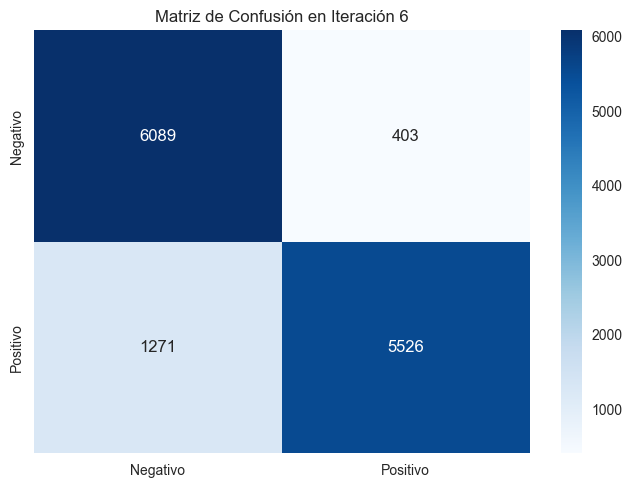

[I 2024-12-12 00:57:13,270] Trial 6 finished with value: 0.8533879459283508 and parameters: {'n_estimators': 472, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.8533879459283508.
[I 2024-12-12 00:58:07,865] Trial 8 finished with value: 0.8427724653645547 and parameters: {'n_estimators': 401, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 6 with value: 0.8533879459283508.


F1 score en iteración 8: 0.8575719253872905
AUC-PR en iteración 8: 0.8427724653645547


[I 2024-12-12 00:58:16,230] Trial 5 finished with value: 0.8465519465087115 and parameters: {'n_estimators': 499, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.8533879459283508.


F1 score en iteración 5: 0.861157155260873
AUC-PR en iteración 5: 0.8465519465087115
F1 score en iteración 3: 0.8695317313616759
AUC-PR en iteración 3: 0.8444461973358843


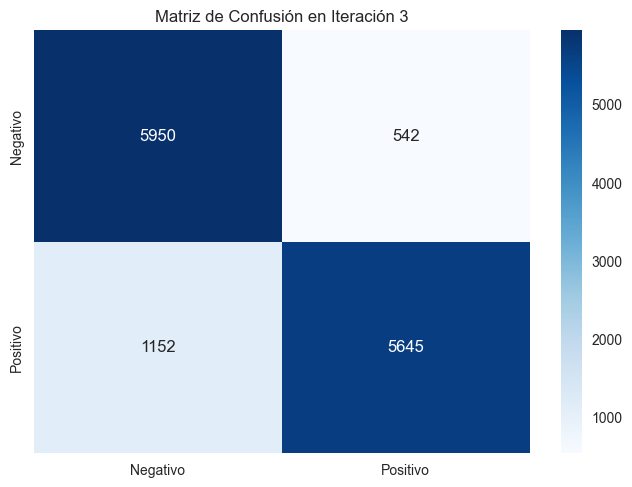

[I 2024-12-12 01:01:47,388] Trial 3 finished with value: 0.8444461973358843 and parameters: {'n_estimators': 433, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.9}. Best is trial 6 with value: 0.8533879459283508.
[I 2024-12-12 01:03:53,739] Trial 10 finished with value: 0.8434202276914559 and parameters: {'n_estimators': 1339, 'max_depth': 42, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 6 with value: 0.8533879459283508.


F1 score en iteración 10: 0.8580237154150198
AUC-PR en iteración 10: 0.8434202276914559
F1 score en iteración 11: 0.8710055473083834
AUC-PR en iteración 11: 0.8536200119375379


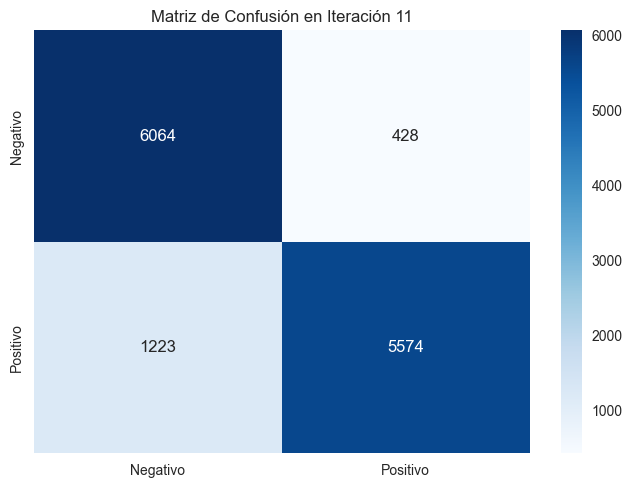

[I 2024-12-12 01:04:02,634] Trial 11 finished with value: 0.8536200119375379 and parameters: {'n_estimators': 889, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 11 with value: 0.8536200119375379.


F1 score en iteración 9: 0.8751149249157217
AUC-PR en iteración 9: 0.8488707479025557


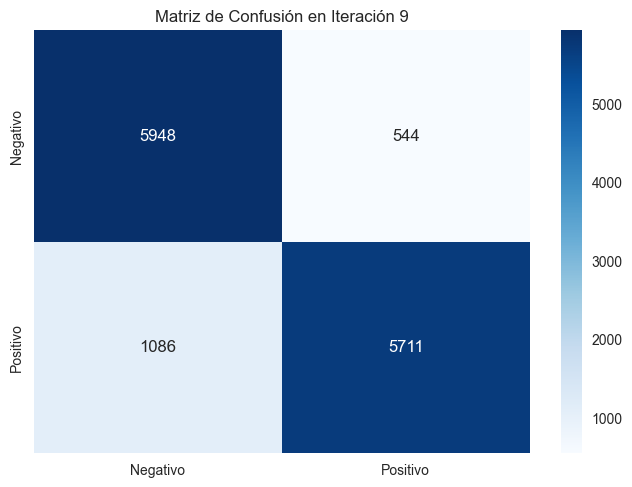

[I 2024-12-12 01:06:18,285] Trial 9 finished with value: 0.8488707479025557 and parameters: {'n_estimators': 513, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0}. Best is trial 11 with value: 0.8536200119375379.
[I 2024-12-12 01:07:24,063] Trial 13 finished with value: 0.8588469020995788 and parameters: {'n_estimators': 1301, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 13 with value: 0.8588469020995788.


F1 score en iteración 13: 0.873243858409858
AUC-PR en iteración 13: 0.8588469020995788


[I 2024-12-12 01:10:13,121] Trial 12 finished with value: 0.8534876722075281 and parameters: {'n_estimators': 1471, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 13 with value: 0.8588469020995788.


F1 score en iteración 12: 0.8704833411543876
AUC-PR en iteración 12: 0.8534876722075281
F1 score en iteración 15: 0.8754213913576463
AUC-PR en iteración 15: 0.8492576548439488


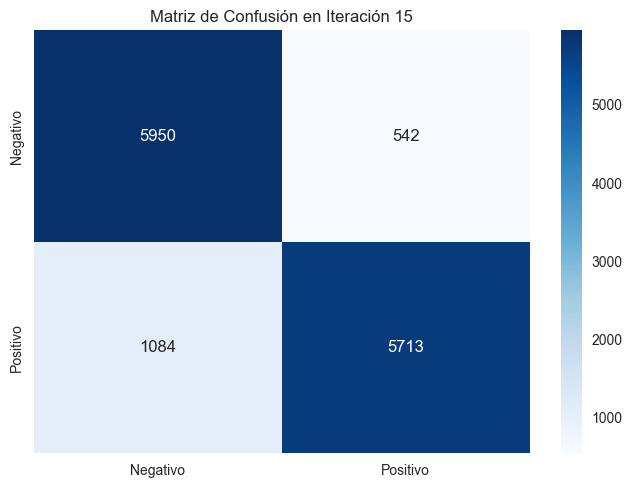

[I 2024-12-12 01:13:20,394] Trial 15 finished with value: 0.8492576548439488 and parameters: {'n_estimators': 415, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9}. Best is trial 13 with value: 0.8588469020995788.
[I 2024-12-12 01:13:29,993] Trial 14 finished with value: 0.8448952350349817 and parameters: {'n_estimators': 526, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.9}. Best is trial 13 with value: 0.8588469020995788.


F1 score en iteración 14: 0.8705013841894802
AUC-PR en iteración 14: 0.8448952350349817
F1 score en iteración 18: 0.8697568269457779
AUC-PR en iteración 18: 0.8558240125485354


[I 2024-12-12 01:16:20,579] Trial 18 finished with value: 0.8558240125485354 and parameters: {'n_estimators': 992, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 13 with value: 0.8588469020995788.


F1 score en iteración 1: 0.8709429318566374
AUC-PR en iteración 1: 0.845526385107095


[I 2024-12-12 01:16:50,272] Trial 1 finished with value: 0.845526385107095 and parameters: {'n_estimators': 859, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.9}. Best is trial 13 with value: 0.8588469020995788.


F1 score en iteración 2: 0.8644146228597871
AUC-PR en iteración 2: 0.8387431358954841


[I 2024-12-12 01:17:35,352] Trial 2 finished with value: 0.8387431358954841 and parameters: {'n_estimators': 1470, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 1.0}. Best is trial 13 with value: 0.8588469020995788.


In [ ]:
# Modelo inicial
initial_model = ExtraTreesClassifier(random_state=123)
initial_pipeline = create_pipeline(initial_model)

# Entrenar el modelo inicial sin optimización de parámetros
initial_pipeline.fit(data_train, y_train)

# Evaluación inicial en el conjunto de test
initial_y_pred = initial_pipeline.predict(data_val)
initial_f1 = f1_score(y_val, initial_y_pred)
print(f'Rendimiento inicial (F1) en X_test: {initial_f1}')

# Crear la función objetivo para Optuna
def objective(trial):
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 400, 1500)
    max_depth = trial.suggest_int('max_depth', 25, 45)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 3)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.9, 1.0])
    #max_features=trial.choice(['sqrt', 'log2', None, 0.5, 0.8])
    
    # Definir el modelo ExtraTreesClassifier con los hiperparámetros sugeridos
    model = ExtraTreesClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 random_state=123)
    
    # Crear el pipeline
    pipeline = create_pipeline(model)
    
    # Entrenar el modelo
    pipeline.fit(data_train, y_train)
    
    # Realizar predicciones en el conjunto de validación
    y_pred = pipeline.predict(data_val)
    
    # Calcular F1 score en el conjunto de validación
    f1 = f1_score(y_val, y_pred)
    auc_pr = average_precision_score(y_val, y_pred)
    
    # Mostrar el rendimiento durante cada iteración
    print(f'F1 score en iteración {trial.number}: {f1}')
    print(f'AUC-PR en iteración {trial.number}: {auc_pr}')
    
    # Imprimir matriz de confusión solo si mejora el F1 anterior
    global best_f1
    if f1 > best_f1:
        best_f1 = f1
        cm = confusion_matrix(y_val, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
        plt.title(f'Matriz de Confusión en Iteración {trial.number}')
        plt.show()

    return auc_pr  # Queremos maximizar AUC-PR

best_f1 = 0.0

# Configurar y ejecutar el estudio Optuna
study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=50, n_jobs=-1)  

# Mejor conjunto de parámetros encontrados
best_params = study.best_params
print(f'Mejores parámetros encontrados: {best_params}')

# Crear el modelo final con los mejores parámetros
final_model = ExtraTreesClassifier(**best_params, random_state=123)

# Crear el pipeline final con el preprocesador
final_pipeline = create_pipeline(final_model)

# Entrenar el modelo final
final_pipeline.fit(data_train, y_train)

# Guardar el escalador (transformador) para uso posterior
joblib.dump(final_pipeline.named_steps['preprocessing'], 'scaler.pkl')

# Evaluación final en el conjunto de test con la métrica F1
final_y_pred = final_pipeline.predict(data_val)
final_f1 = f1_score(y_val, final_y_pred)
final_auc = average_precision_score(y_val, final_y_pred)
print(f'Rendimiento final en X_test: (F1) = {final_f1} | AUC-PR = {final_auc}')

# Mostrar la matriz de confusión final
final_cm = confusion_matrix(y_val, final_y_pred)
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión Final')
plt.show()

# Guardar el pipeline final para uso posterior
joblib.dump(final_pipeline, 'final_pipeline.pkl')

In [13]:
# Guardar el pipeline final y el modelo para uso posterior
mod = 'ETC'
f1_nombre = str(final_f1)
auc_nombre = str(final_auc)
joblib.dump(final_pipeline, f'final_pipeline_{mod}_f1_{f1_nombre}_auc{auc_nombre}.pkl')
joblib.dump(final_model, f'{mod}_model_f1_{f1_nombre}_auc{auc_nombre}.pkl')

['ETC_model_f1_0.881568749031158_auc0.8629333233190027.pkl']

### CP para HP

In [14]:
import plotly.express as px

# Obtener los resultados del estudio de Optuna
trials_df0 = study.trials
trials_data = []

# Extraer los parámetros y el valor de cada ensayo
for trial in trials_df0:
    # Extraer los parámetros y el F1 score
    trial_params = trial.params
    trial_params['F1 Score'] = trial.value  # Añadir el F1 score como una nueva columna
    trials_data.append(trial_params)

# Crear un DataFrame a partir de los resultados
trials_df = pd.DataFrame(trials_data)

# Verificar las columnas del DataFrame
print(trials_df.columns)

# Crear el gráfico de coordenadas paralelas
fig = px.parallel_coordinates(
    trials_df,
    dimensions=['n_estimators', 'max_depth', 'min_samples_split', 
                'min_samples_leaf', 'max_features', 'F1 Score'],
    color='F1 Score',  # Para colorear según el F1 score
    labels={
        'n_estimators': 'Número de Estimadores',
        'max_depth': 'Profundidad Máxima',
        'min_samples_split': 'Mínimo de Muestras para División',
        'min_samples_leaf': 'Mínimo de Muestras para Hoja',
        'max_features': 'Máximo de Características',
        'F1 Score': 'Puntaje F1'
    },
    color_continuous_scale='Blues',  # Cambiar el color del gráfico
    title="Paralel Coordinates: Parámetros y Rendimiento"
)

# Mostrar el gráfico
fig.show()

Index(['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf',
       'max_features', 'F1 Score'],
      dtype='object')


## Random Forest

[I 2024-12-12 16:45:24,771] A new study created in memory with name: no-name-39403043-7a38-434c-a827-b8e4296a48a2


Rendimiento inicial en X_test: (F1) = 0.891747384734599 | AUC-PR = 0.8759726069149126


[I 2024-12-12 16:47:43,003] Trial 0 finished with value: 0.7807521752030107 and parameters: {'n_estimators': 53, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 1.0, 'bootstrap': False}. Best is trial 0 with value: 0.7807521752030107.
[I 2024-12-12 16:57:07,154] Trial 1 finished with value: 0.779441218438897 and parameters: {'n_estimators': 106, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 1.0, 'bootstrap': False}. Best is trial 0 with value: 0.7807521752030107.
[I 2024-12-12 16:59:04,794] Trial 2 finished with value: 0.816433578093543 and parameters: {'n_estimators': 28, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 0.9, 'bootstrap': False}. Best is trial 2 with value: 0.816433578093543.
[I 2024-12-12 17:06:39,200] Trial 3 finished with value: 0.8340696771126812 and parameters: {'n_estimators': 194, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 0.9, 'b

F1 score en iteración 10: 0.899938612645795
AUC-PR en iteración 10: 0.8816069337748689


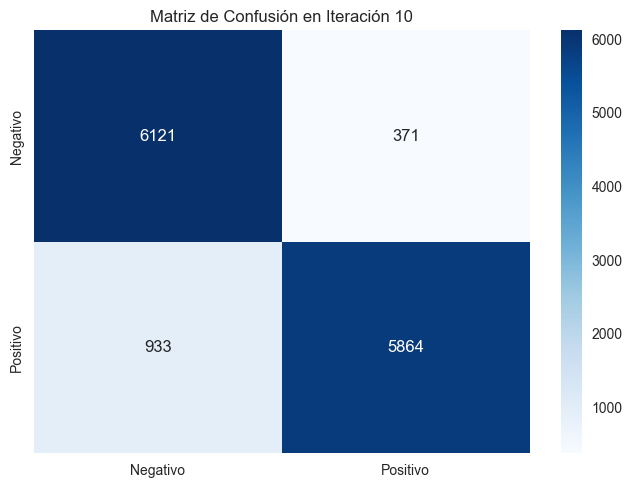

[I 2024-12-12 17:36:40,210] Trial 10 finished with value: 0.8816069337748689 and parameters: {'n_estimators': 289, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 10 with value: 0.8816069337748689.
[I 2024-12-12 17:39:08,260] Trial 11 finished with value: 0.8812040507499691 and parameters: {'n_estimators': 291, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 10 with value: 0.8816069337748689.


F1 score en iteración 12: 0.9017535799065778
AUC-PR en iteración 12: 0.882929034022097


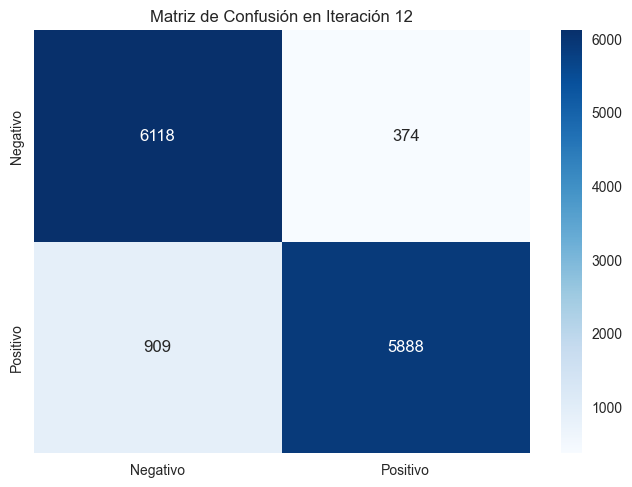

[I 2024-12-12 17:41:10,011] Trial 12 finished with value: 0.882929034022097 and parameters: {'n_estimators': 239, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 12 with value: 0.882929034022097.
[I 2024-12-12 17:43:12,162] Trial 13 finished with value: 0.8827989802785372 and parameters: {'n_estimators': 241, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 12 with value: 0.882929034022097.
[I 2024-12-12 17:45:02,105] Trial 14 finished with value: 0.8727032430417186 and parameters: {'n_estimators': 231, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 12 with value: 0.882929034022097.
[I 2024-12-12 19:28:51,110] Trial 15 finished with value: 0.8787656414361045 and parameters: {'n_estimators': 232, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_f

F1 score en iteración 22: 0.9015122438013357
AUC-PR en iteración 22: 0.8838733342566139


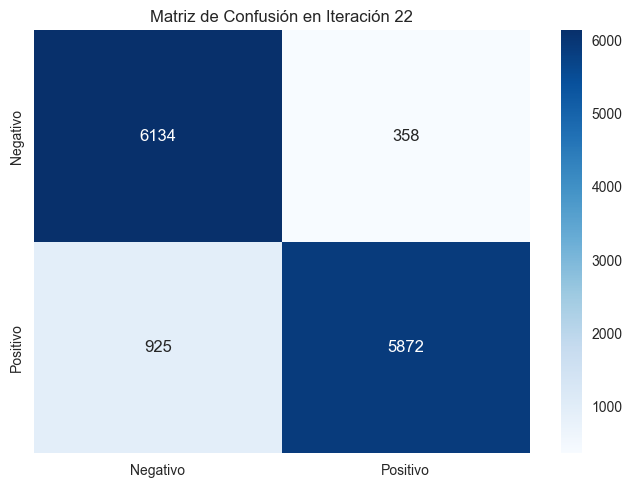

[I 2024-12-12 19:50:33,430] Trial 22 finished with value: 0.8838733342566139 and parameters: {'n_estimators': 253, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 22 with value: 0.8838733342566139.
[I 2024-12-12 19:52:41,063] Trial 23 finished with value: 0.8821497489852397 and parameters: {'n_estimators': 232, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 22 with value: 0.8838733342566139.


F1 score en iteración 24: 0.9012677679600462
AUC-PR en iteración 24: 0.8840275646524444


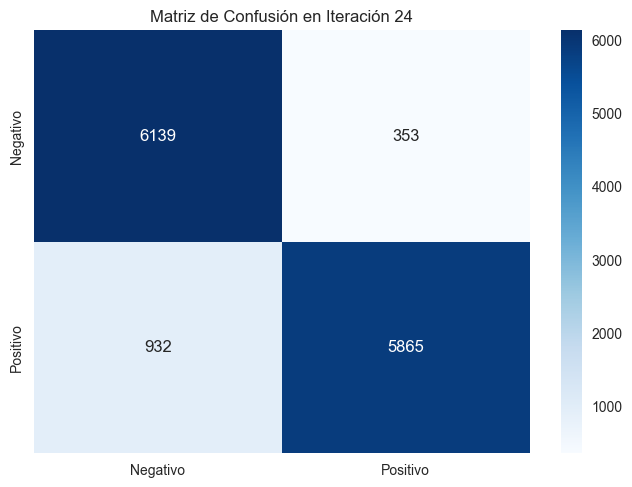

[I 2024-12-12 19:54:46,637] Trial 24 finished with value: 0.8840275646524444 and parameters: {'n_estimators': 300, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 24 with value: 0.8840275646524444.
[I 2024-12-12 19:56:36,643] Trial 25 finished with value: 0.8731581276406057 and parameters: {'n_estimators': 298, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 24 with value: 0.8840275646524444.
[I 2024-12-12 19:57:44,056] Trial 26 finished with value: 0.8652084130824192 and parameters: {'n_estimators': 264, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 24 with value: 0.8840275646524444.
[I 2024-12-12 19:59:06,125] Trial 27 finished with value: 0.87993404978452 and parameters: {'n_estimators': 210, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_

F1 score en iteración 62: 0.9020119797266165
AUC-PR en iteración 62: 0.8847296989389077


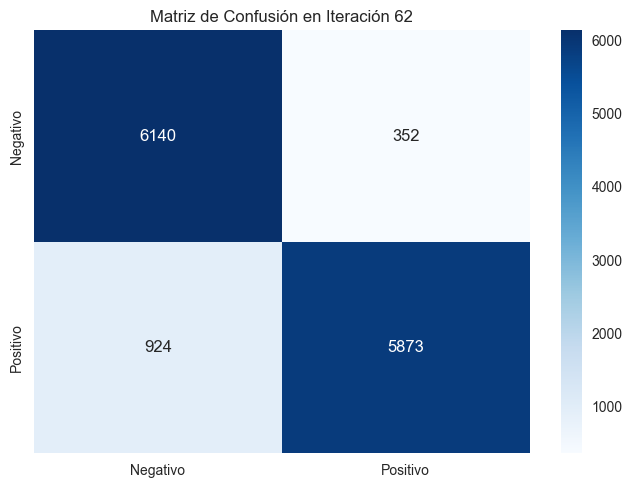

[I 2024-12-12 22:20:09,190] Trial 62 finished with value: 0.8847296989389077 and parameters: {'n_estimators': 287, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 62 with value: 0.8847296989389077.
[I 2024-12-12 22:21:36,864] Trial 63 finished with value: 0.8815881098728737 and parameters: {'n_estimators': 291, 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 62 with value: 0.8847296989389077.
[I 2024-12-12 22:23:05,196] Trial 64 finished with value: 0.8818548092630212 and parameters: {'n_estimators': 294, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 62 with value: 0.8847296989389077.
[I 2024-12-12 22:24:11,810] Trial 65 finished with value: 0.8797923033578736 and parameters: {'n_estimators': 258, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 2, 'm

F1 score en iteración 81: 0.9020995154964239
AUC-PR en iteración 81: 0.8856013210916055


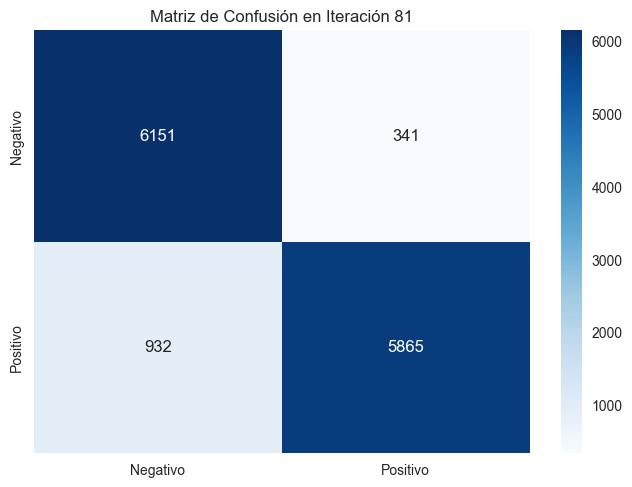

[I 2024-12-12 22:43:40,099] Trial 81 finished with value: 0.8856013210916055 and parameters: {'n_estimators': 293, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 81 with value: 0.8856013210916055.
[I 2024-12-12 22:44:36,303] Trial 82 finished with value: 0.88541003031523 and parameters: {'n_estimators': 296, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 81 with value: 0.8856013210916055.
[I 2024-12-12 22:45:30,952] Trial 83 finished with value: 0.8856013210916055 and parameters: {'n_estimators': 293, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 81 with value: 0.8856013210916055.
[I 2024-12-12 22:46:22,315] Trial 84 finished with value: 0.8812196252299367 and parameters: {'n_estimators': 293, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max

F1 score en iteración 104: 0.9020844550419198
AUC-PR en iteración 104: 0.8856613105014567


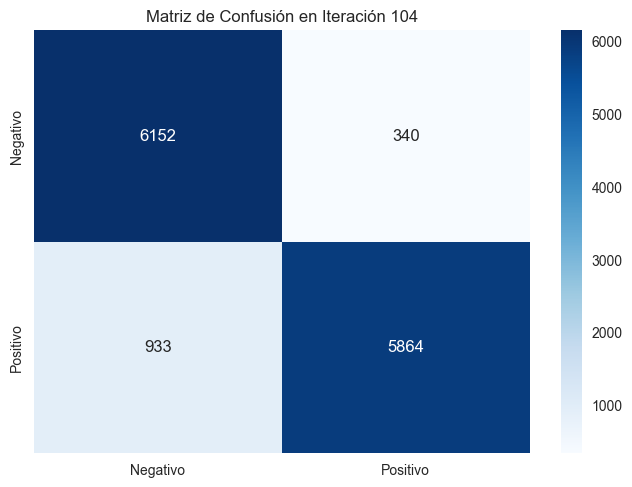

[I 2024-12-12 23:11:09,478] Trial 104 finished with value: 0.8856613105014567 and parameters: {'n_estimators': 294, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 104 with value: 0.8856613105014567.
[I 2024-12-12 23:12:01,136] Trial 105 finished with value: 0.8852556623433201 and parameters: {'n_estimators': 290, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 104 with value: 0.8856613105014567.
[I 2024-12-12 23:23:17,857] Trial 106 finished with value: 0.7836067863588938 and parameters: {'n_estimators': 295, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'bootstrap': False}. Best is trial 104 with value: 0.8856613105014567.
[I 2024-12-12 23:24:10,749] Trial 107 finished with value: 0.8807674394477745 and parameters: {'n_estimators': 295, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2

KeyboardInterrupt: 

In [6]:
# Modelo inicial
initial_model = RandomForestClassifier(random_state=123)
initial_pipeline = create_pipeline(initial_model)

# Entrenar el modelo inicial sin optimización de parámetros
initial_pipeline.fit(data_train, y_train)

# Evaluación inicial en el conjunto de test
initial_y_pred = initial_pipeline.predict(data_val)
initial_f1 = f1_score(y_val, initial_y_pred)
initial_auc_pr = average_precision_score(y_val, initial_y_pred)
print(f'Rendimiento inicial en X_test: (F1) = {initial_f1} | AUC-PR = {initial_auc_pr}')

# Crear la función objetivo para Optuna
def objective(trial):
    # Definir los hiperparámetros a optimizar
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 300),
        "max_depth": trial.suggest_int("max_depth", 15, 35),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.9, 1.0]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
    }
    
    # Entrena el modelo
    model = RandomForestClassifier(
        random_state=17,
        **params
    )
    
    # Crear el pipeline
    pipeline = create_pipeline(model)
    
    # Entrenar el modelo
    pipeline.fit(data_train, y_train)
    
    # Realizar predicciones en el conjunto de validación
    y_pred = pipeline.predict(data_val)
    
    # Calcular F1 score en el conjunto de validación
    f1 = f1_score(y_val, y_pred)
    auc_pr = average_precision_score(y_val, y_pred)
    
    # Imprimir matriz de confusión solo si mejora el F1 anterior
    global best_auc_pr
    if auc_pr > best_auc_pr:
        best_auc_pr = auc_pr
        # Mostrar el rendimiento durante cada iteración
        print(f'F1 score en iteración {trial.number}: {f1}')
        print(f'AUC-PR en iteración {trial.number}: {auc_pr}')
        cm = confusion_matrix(y_val, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
        plt.title(f'Matriz de Confusión en Iteración {trial.number}')
        plt.show()

    return auc_pr  # Queremos maximizar AUC-PR

best_auc_pr = initial_auc_pr

# Configurar y ejecutar el estudio Optuna
study_rf = optuna.create_study(direction='maximize')  
study_rf.optimize(objective, n_trials=200, n_jobs=1)  

# Mejor conjunto de parámetros encontrados
best_params_rf = study_rf.best_params
print(f'Mejores parámetros encontrados: {best_params_rf}')

# Crear el modelo final con los mejores parámetros
final_model_rf = RandomForestClassifier(**best_params_rf, random_state=123)

# Crear el pipeline final con el preprocesador
final_pipeline_rf = create_pipeline(final_model_rf)

# Entrenar el modelo final
final_pipeline_rf.fit(data_train, y_train)

# Guardar el escalador (transformador) para uso posterior
joblib.dump(final_pipeline_rf.named_steps['preprocessing'], 'scaler.pkl')

# Evaluación final en el conjunto de test con la métrica F1
final_y_pred = final_pipeline_rf.predict(data_val)
final_f1 = f1_score(y_val, final_y_pred)
final_auc = average_precision_score(y_val, final_y_pred)
print(f'Rendimiento final en X_test: (F1) = {final_f1} | AUC-PR = {final_auc}')

# Mostrar la matriz de confusión final
final_cm_rf = confusion_matrix(y_val, final_y_pred)
sns.heatmap(final_cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión Final')
plt.show()

# Guardar el pipeline final para uso posterior
joblib.dump(final_pipeline_rf, 'final_pipeline.pkl')

[I 2024-12-12 23:11:09,478] Trial 104 finished with value: 0.8856613105014567 and parameters: {'n_estimators': 294, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 104 with value: 0.8856613105014567

F1 score en iteración 104: 0.9020844550419198
AUC-PR en iteración 104: 0.8856613105014567

Mejores parámetros encontrados: {'n_estimators': 294, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}
Rendimiento final en X_test: (F1) = 0.9013889954723352 | AUC-PR = 0.8835528002270768


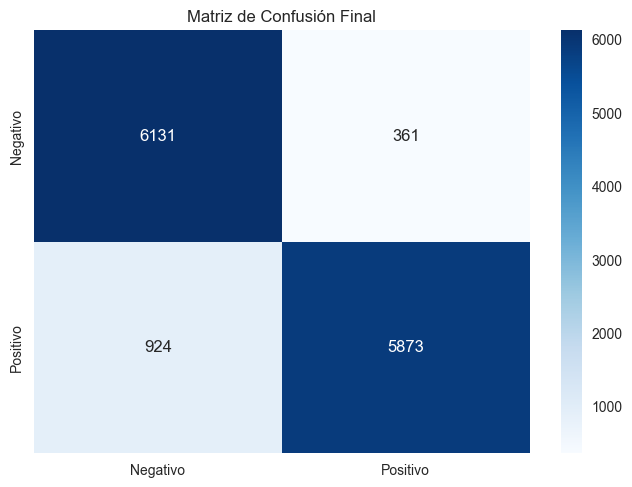

In [8]:
# Mejor conjunto de parámetros encontrados
best_params_rf = {
    'n_estimators': 294,
    'max_depth': 28,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'bootstrap': False
}

#best_params_rf = study_rf.best_params
print(f'Mejores parámetros encontrados: {best_params_rf}')

# Crear el modelo final con los mejores parámetros
final_model_rf = RandomForestClassifier(**best_params_rf, random_state=123)

# Crear el pipeline final con el preprocesador
final_pipeline_rf = create_pipeline(final_model_rf)

# Entrenar el modelo final
final_pipeline_rf.fit(data_train, y_train)

# Guardar el escalador (transformador) para uso posterior
joblib.dump(final_pipeline_rf.named_steps['preprocessing'], 'scaler.pkl')

# Evaluación final en el conjunto de test con la métrica F1
final_y_pred = final_pipeline_rf.predict(data_val)
final_f1 = f1_score(y_val, final_y_pred)
final_auc = average_precision_score(y_val, final_y_pred)
print(f'Rendimiento final en X_test: (F1) = {final_f1} | AUC-PR = {final_auc}')

# Mostrar la matriz de confusión final
final_cm_rf = confusion_matrix(y_val, final_y_pred)
sns.heatmap(final_cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión Final')
plt.show()

In [10]:
# Guardar el pipeline final y el modelo para uso posterior
mod = 'RF'
f1_nombre = str(final_f1)
auc_nombre = str(final_auc)
joblib.dump(final_pipeline_rf, f'final_pipeline_{mod}_f1_{f1_nombre}_auc{auc_nombre}.pkl')
joblib.dump(final_model_rf, f'{mod}_model_f1_{f1_nombre}_auc{auc_nombre}.pkl')

['RF_model_f1_0.9013889954723352_auc0.8835528002270768.pkl']

In [7]:
import plotly.express as px

# Obtener los resultados del estudio de Optuna
trials_df0_rf = study_rf.trials
trials_data_rf = []

# Extraer los parámetros y el valor de cada ensayo
for trial in trials_df0_rf:
    # Extraer los parámetros y el F1 score
    trial_params = trial.params
    trial_params['F1 Score'] = trial.value  # Añadir el F1 score como una nueva columna
    trials_data_rf.append(trial_params)

# Crear un DataFrame a partir de los resultados
trials_df_rf = pd.DataFrame(trials_data_rf)

# Verificar las columnas del DataFrame
print(trials_df_rf.columns)

# Crear el gráfico de coordenadas paralelas para Random Forest
fig_rf = px.parallel_coordinates(
    trials_df_rf,
    dimensions=['n_estimators', 'max_depth', 'min_samples_split',
                 'min_samples_leaf', 'max_features', 'bootstrap', 'F1 Score'],
    color='F1 Score',  # Para colorear según el F1 score
    labels={
        'n_estimators': 'Número de Estimadores',
        'max_depth': 'Profundidad Máxima',
        'min_samples_split': 'Mínimo de Muestras para División',
        'min_samples_leaf': 'Mínimo de Muestras para Hoja',
        'max_features': 'Máximo de Características',
        'bootstrap': 'Bootstrap',
        'F1 Score': 'Puntaje F1'
    },
    color_continuous_scale='Blues',  # Cambiar el color del gráfico
    title="Paralel Coordinates: Parámetros y Rendimiento (Random Forest)"
)

# Mostrar el gráfico
fig_rf.show()

Index(['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf',
       'max_features', 'bootstrap', 'F1 Score'],
      dtype='object')


## XGBoost

In [ ]:
# Modelo inicial
initial_model =  XGBClassifier(**best_params_xgb, random_state=123)
#initial_model =  XGBClassifier(random_state=123)
initial_pipeline = create_pipeline(initial_model)

# Entrenar el modelo inicial sin optimización de parámetros
initial_pipeline.fit(data_train, y_train)

# Evaluación inicial en el conjunto de test
initial_y_pred = initial_pipeline.predict(data_val)
initial_f1 = f1_score(y_val, initial_y_pred)
print(f'Rendimiento inicial (F1) en X_test: {initial_f1}')

# Crear la función objetivo para Optuna
def objective(trial):
    # Definir los hiperparámetros a optimizar
    params = {
        "objective": "binary:logistic",  # Para clasificación binaria
        "eval_metric": "aucpr",  # Métrica usada durante el entrenamiento
        "max_depth": trial.suggest_int("max_depth", 14, 26),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.2),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 3),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
    }
    
    # Entrena el modelo
    model =  XGBClassifier(
        random_state=17,
        **params
    )
    
    # Crear el pipeline
    pipeline = create_pipeline(model)
    
    # Entrenar el modelo
    pipeline.fit(data_train, y_train)
    
    # Realizar predicciones en el conjunto de validación
    y_pred = pipeline.predict(data_val)
    
    # Calcular F1 score en el conjunto de validación
    f1 = f1_score(y_val, y_pred)
    auc_pr = average_precision_score(y_val, y_pred)
    
    # Mostrar el rendimiento durante cada iteración
    print(f'F1 score en iteración {trial.number}: {f1}')
    print(f'AUC-PR en iteración {trial.number}: {auc_pr}')
    
    # Imprimir matriz de confusión solo si mejora el F1 anterior
    global best_f1
    if f1 > best_f1:
        best_f1 = f1
        cm = confusion_matrix(y_val, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
        plt.title(f'Matriz de Confusión en Iteración {trial.number}')
        plt.show()

    return auc_pr  # Queremos maximizar AUC-PR

best_f1 = 0.0

# Configurar y ejecutar el estudio Optuna
study_xgb = optuna.create_study(direction='maximize')  
study_xgb.optimize(objective, n_trials=50, n_jobs=-1)  

# Mejor conjunto de parámetros encontrados
best_params_xgb = study_xgb.best_params
print(f'Mejores parámetros encontrados: {best_params_xgb}')

# Crear el modelo final con los mejores parámetros
final_model_xgb = XGBClassifier(**best_params_xgb, random_state=123)

# Crear el pipeline final con el preprocesador
final_pipeline_xgb = create_pipeline(final_model_xgb)

# Entrenar el modelo final
final_pipeline_xgb.fit(data_train, y_train)

# Guardar el escalador (transformador) para uso posterior
joblib.dump(final_pipeline_xgb.named_steps['preprocessing'], 'scaler.pkl')

# Evaluación final en el conjunto de test con la métrica F1
final_y_pred = final_pipeline_xgb.predict(data_val)
final_f1 = f1_score(y_val, final_y_pred)
final_auc = average_precision_score(y_val, final_y_pred)
print(f'Rendimiento final en X_test: (F1) = {final_f1} | AUC-PR = {final_auc}')

# Mostrar la matriz de confusión final
final_cm_xgb = confusion_matrix(y_val, final_y_pred)
sns.heatmap(final_cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión Final')
plt.show()

# Guardar el pipeline final para uso posterior
joblib.dump(final_pipeline_xgb, 'final_pipeline.pkl')

[I 2024-12-12 00:53:16,461] A new study created in memory with name: no-name-60c3e9f8-037b-4789-bc94-d98756959e58


Rendimiento inicial (F1) en X_test: 0.9018980105190945


In [23]:
# Guardar el pipeline final y el modelo para uso posterior
mod = 'XGB'
f1_nombre = str(final_f1)
auc_nombre = str(final_auc)
joblib.dump(final_pipeline, f'final_pipeline_{mod}_f1_{f1_nombre}_auc{auc_nombre}.pkl')
joblib.dump(final_model, f'{mod}_model_f1_{f1_nombre}_auc{auc_nombre}.pkl')

['XGB_model_f1_0.9018980105190945_auc0.8807832055205326.pkl']

In [24]:
# Obtener los resultados del estudio de Optuna
trials_df0_xgb = study_xgb.trials
trials_data_xgb = []

# Extraer los parámetros y el valor de cada ensayo
for trial in trials_df0_xgb:
    # Extraer los parámetros y el F1 score
    trial_params = trial.params
    trial_params['F1 Score'] = trial.value  # Añadir el F1 score como una nueva columna
    trials_data_xgb.append(trial_params)

# Crear un DataFrame para los resultados de XGBoost
trials_df_xgb = pd.DataFrame(trials_data_xgb)

# Verificar las columnas del DataFrame
print(trials_df_xgb.columns)

# Crear el gráfico de coordenadas paralelas para XGBoost
fig_xgb = px.parallel_coordinates(
    trials_df_xgb,
    dimensions=['max_depth', 'learning_rate', 'subsample', 'colsample_bytree',
                 'min_child_weight', 'gamma', 'n_estimators', 'F1 Score'],
    color='F1 Score',  # Para colorear según el F1 score
    labels={
        'max_depth': 'Profundidad Máxima',
        'learning_rate': 'Tasa de Aprendizaje',
        'subsample': 'Submuestreo',
        'colsample_bytree': 'Submuestreo de Columnas',
        'min_child_weight': 'Peso Mínimo de Hoja',
        'gamma': 'Valor Gamma',
        'n_estimators': 'Número de Estimadores',
        'F1 Score': 'Puntaje F1'
    },
    color_continuous_scale='Blues',  # Cambiar el color del gráfico
    title="Paralel Coordinates: Parámetros y Rendimiento (XGBoost)"
)

# Mostrar el gráfico
fig_xgb.show()

Index(['max_depth', 'learning_rate', 'subsample', 'colsample_bytree',
       'min_child_weight', 'gamma', 'n_estimators', 'F1 Score'],
      dtype='object')
